# CODE

In [1]:

using PauliPropagation
using Random
using Optim
using Plots
using ReverseDiff: GradientTape, gradient!, compile, gradient
using LinearAlgebra
using StatsBase 
using GLM
using DataFrames
using CSV
using Format
using Logging
using Distributions
using LaTeXStrings
using MLJLinearModels
using MLJBase
using Dates 
using LsqFit
using StatsModels

################# Logging Setup ####################
struct UnbufferedLogger <: Logging.AbstractLogger
    stream::IO
    level::Logging.LogLevel
end

const MainInfo = Base.CoreLogging.LogLevel(200)
const SubInfo = Base.CoreLogging.LogLevel(100)

const LOG_LEVEL_NAMES = Dict(
    Logging.Debug => "Debug",
    Logging.Info => "Info",
    Logging.Warn => "Warn",
    Logging.Error => "Error",
    SubInfo => "SubInfo",
    MainInfo => "MainInfo"
)

Logging.min_enabled_level(logger::UnbufferedLogger) = logger.level
Logging.shouldlog(logger::UnbufferedLogger, level, _module, group, id) = level ≥ logger.level
Logging.catch_exceptions(::UnbufferedLogger) = true

function Logging.handle_message(logger::UnbufferedLogger, level, message, _module, group, id, file, line; kwargs...)
    level_name = get(LOG_LEVEL_NAMES, level, "$level")  # Default for custom levels
    print(logger.stream, "[$level_name] ", message, "\n")  # Include log level
    flush(logger.stream)  # Ensure immediate output
end



#################### Structure and Setup ####################
struct trotter_ansatz_tfim
    target_circuit::Vector{Gate}
    target_circuit_layer::Vector{Gate}
    topology::Vector{Tuple{Int64, Int64}}
    nqubits::Integer
    steps::Integer # layers
    time::Float64
    J::Float64
    h::Float64
    theta_J::Float64
    theta_h::Float64
    theta_J_indices::Vector{Int64}
    theta_h_indices::Vector{Int64}
    theta_J_indices_layer::Vector{Int64}
    theta_h_indices_layer::Vector{Int64}
end


function kickedisingcircuit(nq, nl; topology=nothing)

    """
    generates a circuit with nq qubits and nl layers where the RX angle is a variable and the RZZ angle is fixed to -π/2
    """

    if isnothing(topology)
        topology = bricklayertopology(nq)
    end
    
    xlayer(circuit) = append!(circuit, (PauliRotation([:X], [qind]) for qind in 1:nq))
    zzlayer(circuit) = append!(circuit, (PauliRotation([:Z, :Z], pair, -π/2) for pair in topology))
    #Question: why does Manuel have π/2 here? It's not the same physically
    circuit = Gate[]

    for _ in 1:nl
        zzlayer(circuit)
        xlayer(circuit)
    end

    return circuit
end

function kickedisinglayer(nq; topology=nothing)

    """
    generates a circuit with nq qubits and nl layers where the RX angle is a variable and the RZZ angle is fixed to -π/2
    """

    if isnothing(topology)
        topology = bricklayertopology(nq)
    end
    
    # xlayer(circuit) = append!(circuit, (PauliRotation([:X], [qind]) for qind in 1:nq))
    # zzlayer(circuit) = append!(circuit, (PauliRotation([:Z, :Z], pair, -π/2) for pair in topology))

    #Question: why does Manuel have π/2 here? It's not the same physically
    layer = Gate[]
    append!(layer, (PauliRotation([:X], [qind]) for qind in 1:nq))
    append!(layer, (PauliRotation([:Z, :Z], pair, -π/2) for pair in topology))

    return layer
end

# function trotter_setup(nqubits::Integer, steps::Integer, time::Float64, J::Float64, h::Float64;topology = nothing)

#     """
#     setup for the trotter ansatz of the TFIM
#     """

#     if isnothing(topology)
#         topology = bricklayertopology(nqubits)
#     end
#     target_circuit = tfitrottercircuit(nqubits,steps,topology=topology) #starts with RZZ layer
#     target_circuit_layer = tfitrottercircuit(nqubits, 1,topology=topology) #starts with RZZ layer
#     theta_J = -2*time*J/steps
#     theta_h = 2*time*h/steps 

#     theta_J_indices = getparameterindices(target_circuit, PauliRotation, [:Z,:Z]) 
#     theta_h_indices = getparameterindices(target_circuit, PauliRotation, [:X])
    
#     theta_J_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:Z,:Z])
#     theta_h_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:X])
    
#     return trotter_ansatz_tfim(target_circuit,target_circuit_layer, topology, nqubits, steps, time, J, h,theta_J, theta_h,theta_J_indices, theta_h_indices, theta_J_indices_layer, theta_h_indices_layer)
# end

# function trotter_kickedising_setup(nqubits::Integer, steps::Integer, time::Float64, h::Float64;topology = nothing)

#     """
#     setup for the trotter ansatz of the kicked TFIM
#     """

#     if isnothing(topology)
#         topology = bricklayertopology(nqubits)
#     end
#     target_circuit = kickedisingcircuit(nqubits,steps,topology=topology) #starts with RZZ layer
#     target_circuit_layer = kickedisinglayer(nqubits, topology=topology) #starts with RZZ layer
#     theta_J = -pi/2 
#     J = -theta_J*steps/(2*time)
#     theta_h = 2*time*h/steps 

#     theta_J_indices = getparameterindices(target_circuit, PauliRotation, [:Z,:Z]) 
#     theta_h_indices = getparameterindices(target_circuit, PauliRotation, [:X])
    
#     theta_J_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:Z,:Z])
#     theta_h_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:X])
    
#     return trotter_ansatz_tfim(target_circuit,target_circuit_layer, topology, nqubits, steps, time, J, h,theta_J, theta_h,theta_J_indices, theta_h_indices, theta_J_indices_layer, theta_h_indices_layer)
# end


# REPLACED BY define_thetas()?
# function constrain_params(ansatz; layer=false)

#     """
#     Set all RX gates and all RZZ gates to have the same parameter value respectively.
#     """

#     if layer
#         nparams = countparameters(ansatz.target_circuit_layer)
#         thetas = zeros(nparams)
#         thetas[ansatz.theta_h_indices_layer] .= ansatz.theta_h
#         thetas[ansatz.theta_J_indices_layer] .= ansatz.theta_J
#     else
#         nparams = countparameters(ansatz.target_circuit)
#         thetas = zeros(nparams)
#         thetas[ansatz.theta_h_indices] .= ansatz.theta_h
#         thetas[ansatz.theta_J_indices] .= ansatz.theta_J
#     end
    
#     return thetas
# end

function obs_interaction(nq, topology)

    """
    Returns the normalised interaction observable sum_{ij} Z_i Z_j.
    """

    interaction = PauliSum(nq)
    
    for i in 1:length(topology)
        q1 = topology[i][1]
        q2 = topology[i][2]
        add!(interaction, [:Z, :Z], [q1, q2])
    end
    return interaction/length(topology)
end

function obs_magnetization(nq)

    """
    Returns the normalised magnetization observable sum_i Z_i.
    """

    magnetization = PauliSum(nq)
    for i in 1:nq
        add!(magnetization,:Z,i)
    end
    magnetization = magnetization/nq
    return magnetization
end

#################### Training set generation ####################

function training_circuit_generation_brut(ansatz::trotter_ansatz_tfim, angle_definition::Float64=pi/2; num_samples::Int = 10, non_replaced_gates::Int = 30)

    """
    Generates a training set of thetas for the ansatz. The training set is generated by selecting a number of Clifford gates and non-Clifford gates
    and setting the corresponding thetas to multiples of angle_definition. This circuit set generation method is only for testing purposes, since it does not scale for large systems. 
    """

    nparams = countparameters(ansatz.target_circuit)
    replaced_gates = nparams - non_replaced_gates
    ratio = length(ansatz.theta_J_indices)/(length(ansatz.theta_h_indices)+length(ansatz.theta_J_indices))
    num_h = Int(round((1-ratio)*replaced_gates))
    num_J = Int(round(ratio*replaced_gates))
    training_thetas_list = Vector{Vector{Float64}}()
    thetas = constrain_params(ansatz)
    k_h =round(ansatz.theta_h/(angle_definition))
    k_J =round(ansatz.theta_J/(angle_definition))
    
    
    for _ in 1:num_samples
        training_thetas = deepcopy(thetas)
        shuffled_theta_h_indices =  Random.shuffle!(ansatz.theta_h_indices)
        shuffled_theta_J_indices = Random.shuffle!(ansatz.theta_J_indices)
        selected_indices_h = shuffled_theta_h_indices[1:num_h]
        selected_indices_J = shuffled_theta_J_indices[1:num_J]

        for i in selected_indices_h
            training_thetas[i] = k_h*angle_definition
        end
        for i in selected_indices_J
            training_thetas[i] = k_J*angle_definition
        end
        push!(training_thetas_list, training_thetas)
    end
    return training_thetas_list
end

function training_circuit_generation_strict_perturbation(ansatz::trotter_ansatz_tfim,angle_definition::Float64 = pi/20; sample_function = nothing, num_samples::Int = 10)

    """
    Generates a training set according to the CPA approach (http://arxiv.org/abs/2412.09518). We do not use data augmentation here (in the form of ZNE or PEC, then referred to as CPDR-ZNE or CPDR-PEC respectively), but stick to standard CPA.
    Their bound (Theorem 1) only holds if we replace all gates of the circuit, unlike the method in the original CDR paper (http://arxiv.org/abs/2005.10189).
    """

    function sample_theta_CPA(angle_definition)
        # tht_h ∈ [0, angle_definition] ∪ [π/2 - angle_definition, π/2]
        tht_h = rand(Bool) ? rand(Uniform(0.0, angle_definition)) : rand(Uniform(π/2 - angle_definition, π/2))
    
        # tht_J ∈ [−angle_definition, 0] ∪ [−π/2, −π/2 + angle_definition]
        tht_J = rand(Bool) ? rand(Uniform(-angle_definition, 0.0)) : rand(Uniform(-π/2, -π/2 + angle_definition))
    
        return tht_h, tht_J
    end

    function sample_theta_small(angle_definition)
        # tht_h ∈ [0, angle_definition] ∪ [π/2 - angle_definition, π/2]
        tht_h =  rand(Uniform(0.0, angle_definition)) 
    
        # tht_J ∈ [−angle_definition, 0] ∪ [−π/2, −π/2 + angle_definition]
        tht_J = rand(Uniform(-angle_definition, 0.0))
    
        return tht_h, tht_J
    end
    
    if sample_function === nothing
        sample_function = sample_theta_CPA
    elseif sample_function==="CPA"
        sample_function = sample_theta_CPA
    elseif sample_function==="small"
        sample_function = sample_theta_small
    end


    training_thetas_list = Vector{Vector{Float64}}()
    thetas = constrain_params(ansatz)
    training_thetas = deepcopy(thetas)
    
    for _ in 1:num_samples
        tht_h_perturbed, tht_J_perturbed = sample_function(angle_definition)
        training_thetas[ansatz.theta_h_indices] .= tht_h_perturbed
        training_thetas[ansatz.theta_J_indices] .= tht_J_perturbed
        push!(training_thetas_list, copy(training_thetas))
    
    end

    return training_thetas_list
end

#################### Time evolution ####################
function trotter_time_evolution(ansatz; observable = nothing, special_thetas=nothing, noise_kind="noiseless", min_abs_coeff=0.0, max_weight = Inf, noise_level = 1, depol_strength=0.01, dephase_strength=0.01, depol_strength_double=0.0033, dephase_strength_double=0.0033)

    """
    Function that computes the time evolution of the ansatz using the first order Trotter approximation exact time evolution operator.
    The function returns the overlap of the final state with the |0> state.
    """

    if observable===nothing
        obs = obs_interaction(nq, topology)
    else
        obs = deepcopy(observable)
    end

    if special_thetas===nothing
        thetas = constrain_params(ansatz)
    else
        thetas = special_thetas
    end

    # if noise_kind=="naive"
    #     if record
    #         error("Naive noise model doesn't support recording :(")
    #     else
    #         layer = final_noise_layer_circuit(ansatz; depol_strength = noise_level*depol_strength,dephase_strength = noise_level*dephase_strength)
    #     end

    if noise_kind=="gate_ising"
        layer = gate_noise_layer(nq, topology; depol_strength = noise_level*depol_strength, dephase_strength = noise_level*dephase_strength)

    elseif noise_kind=="noiseless"
        layer = ansatz.target_circuit_layer
        
    elseif noise_kind=="realistic_ising"
        layer = realistic_gate_noise_layer(nq, topology; depol_strength_single = noise_level*depol_strength, dephase_strength_single = noise_level*dephase_strength, depol_strength_double = noise_level*depol_strength_double, dephase_strength_double = noise_level*dephase_strength_double)

    elseif noise_kind=="gate_kickedising"
        layer = kicked_gate_noise_layer(nq, topology; depol_strength = noise_level*depol_strength, dephase_strength = noise_level*dephase_strength)

    elseif noise_kind=="realistic_kickedising"
        layer = realistic_kicked_gate_noise_layer(nq, topology; depol_strength_single = noise_level*depol_strength, dephase_strength_single = noise_level*dephase_strength, depol_strength_double = noise_level*depol_strength_double, dephase_strength_double = noise_level*dephase_strength_double)

    else
        error("Noise kind $(noise_kind) unknown.")
    end

    nparams = countparameters(ansatz.target_circuit)
    expvals_trotter = Float64[]   
    push!(expvals_trotter, overlapwithzero(obs))
    for i in 1:ansatz.steps
        psum = propagate!(layer, obs, thetas[Int(nparams/ansatz.steps*(i-1)+1):Int(nparams/ansatz.steps*i)];
        min_abs_coeff=min_abs_coeff, max_weight = max_weight)
        # some functions replicating noise
        push!(expvals_trotter, overlapwithzero(psum))
    end
    return expvals_trotter  
end


function define_thetas(circuit, J, h, dt)
    rzz_indices = getparameterindices(circuit, PauliRotation, [:Z, :Z])
    rx_indices = getparameterindices(circuit, PauliRotation, [:X])

    nparams = countparameters(circuit)

    thetas = zeros(nparams)
    thetas[rzz_indices] .= - J * dt * 2
    thetas[rx_indices] .= h * dt * 2

    return thetas
end

function trotter_time_evolution(nq, nl, topology, layer; observable = nothing, special_thetas=nothing, noise_kind="none", min_abs_coeff=0.0, max_weight = Inf, noise_level = 1.0, depol_strength=0.01, dephase_strength=0.01, depol_strength_double=0.0033, dephase_strength_double=0.0033)

    """
    Function that computes the time evolution of the ansatz using the first order Trotter approximation exact time evolution operator.
    The function returns the overlap of the final state with the |0> state.
    """

    if observable===nothing
        obs = obs_interaction(nq, topology)
    else
        obs = deepcopy(observable)
    end

    if special_thetas===nothing
        error("not implemented")
        # thetas = constrain_params(ansatz)
    else
        thetas = special_thetas
    end


    
    # if noise_kind=="naive"
    #     if record
    #         error("Naive noise model doesn't support recording :(")
    #     else
    #         layer = final_noise_layer_circuit(ansatz; depol_strength = noise_level*depol_strength,dephase_strength = noise_level*dephase_strength)
    #     end


    # nparams = countparameters(ansatz.target_circuit)
    nparams = length(thetas)
    @assert nparams==countparameters(layer) "ERROR: nparams = $nparams != parameters required by the layer = $(countparameters(layer))"
    expvals_trotter = Float64[]   
    push!(expvals_trotter, overlapwithzero(obs))
    for i in 1:nl
        # psum = propagate!(layer, obs, thetas[Int(nparams/nl*(i-1)+1):Int(nparams/nl*i)];
        # min_abs_coeff=min_abs_coeff, max_weight = max_weight)
        psum = propagate!(layer, obs, thetas;
        min_abs_coeff=min_abs_coeff, max_weight = max_weight)
        # some functions replicating noise
        if noise_kind=="both"
            # error("not implemented yet")
            full_noise(psum, depol_strength, noise_level)
        elseif noise_kind=="depolarizing"
            depol_noise(psum, depol_strength, noise_level)
        end
        push!(expvals_trotter, overlapwithzero(psum))
    end
    return expvals_trotter  
end


function full_noise(psum::PauliSum, p::Float64, noise_level::Float64=1.0)
    for (pstr, coeff) in psum
        set!(psum, pstr, coeff*(1-noise_level*p)^countweight(pstr)*(-1)^countxy(pstr))
    end
end

function depol_noise(psum::PauliSum, p::Float64, noise_level::Float64=1.0)
    for (pstr, coeff) in psum
        set!(psum, pstr, coeff*(1-noise_level*p)^countweight(pstr))
    end
end

function dephas_noise(psum::PauliSum)
    for (pstr, coeff) in psum
        set!(psum, pstr, coeff*(-1)^countxy(pstr))
    end
end

######### ZNE isolated implementation ##########
function zne_time_evolution(nq, nl, topology, layer, J, h, dt; observable = nothing, noise_kind="noiseless", min_abs_coeff=0.0, max_weight = Inf, noise_levels = [1,1.5,2.0], depol_strength=0.01, dephase_strength=0.01, depol_strength_double=0.0033, dephase_strength_double=0.0033)

    """
    Function that computes the time evolution of the ansatz using the first order Trotter approximation exact time evolution operator at different noise levels.
    """

    noisy_expvals = Array{Float64,2}(undef, length(noise_levels), nl+1)
    thetas = define_thetas(layer, J, h, dt)
    for (idx,i) in enumerate(noise_levels)
        noisy_expval_target = trotter_time_evolution(nq, nl, topology, layer; special_thetas=thetas, observable = observable, noise_kind=noise_kind, noise_level = i,min_abs_coeff=min_abs_coeff,max_weight = max_weight, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        for j in 1:length(noisy_expval_target)
            noisy_expvals[idx,:] .= noisy_expval_target
        end
    end
    return noisy_expvals
end


# 1st method of ZNE
function zne(noisy_exp::Vector{Float64}; noise_levels = [1,1.5,2.0], fit_type = "linear", exact_target_exp_value::Union{Nothing, Float64}=nothing, use_target::Bool=true)

    """
    Function that computes the ZNE correction for a single noisy expectation value.
    """

    training_data = DataFrame(x=noise_levels, y= noisy_exp)
    if fit_type==="linear"
        ols = lm(@formula(y ~ x), training_data)
        cdr_em(x) = coef(ols)[1] + coef(ols)[2] * x
        corrected = cdr_em(0.0)

    
    elseif fit_type === "exponential"
        model(x, p) = p[1] .+ p[2] .* exp.(-p[3] .* x)
        p0 = [training_data.y[end], training_data.y[1] - training_data.y[end], 1.0]
        fit = curve_fit(model, training_data.x, training_data.y, p0)
        corrected = model(0.0, fit.param)
    
    else @error("Fit type $(fit_type) not supported.")
    
    end

    # ToDo: add polynomial fit (Richardson extrapolation) for comparison
    
    if use_target && exact_target_exp_value !== nothing
        abs_error_after = abs(exact_target_exp_value - corrected) #/ abs(exact_target_exp_value)
        abs_error_before = abs(exact_target_exp_value - noisy_exp[1]) #/ abs(exact_target_exp_value) #fixed to the first noise_level to be one
        return corrected, abs_error_after, abs_error_before
    else
        return corrected

    end
end

# 2nd method of ZNE
function zne(noisy_exp::Matrix{Float64}; noise_levels = [1,1.5,2.0], fit_type = "linear", exact_target_exp_value::Union{Nothing, Vector{Float64}}=nothing, use_target::Bool=true)

    """
    Function that computes the ZNE correction for a set of noisy expectation values to visualize the time evolution of the ZNE correction.
    """

    nsteps = size(noisy_exp,2) #this is one more than nsteps (includes time 0)
    corrected = Vector{Float64}(undef, nsteps) # undef allocates memory (set to 0)
    abs_errors_after = Vector{Float64}()
    abs_errors_before = Vector{Float64}()
    for i in 1:nsteps 
        result = zne(noisy_exp[:,i]; noise_levels = noise_levels, 
        fit_type = fit_type,
         exact_target_exp_value = use_target ? (exact_target_exp_value === nothing ? nothing : exact_target_exp_value[i]) : nothing,
         use_target = use_target)
         if use_target && exact_target_exp_value !== nothing
            corrected[i], err_after, err_before = result
            push!(abs_errors_after, err_after)
            push!(abs_errors_before, err_before)
         else
            corrected[i] = result
            #corrected[i] = max(corrected[i], 1e-16)
        end

        # ToDo: add polynomial fit (Richardson extrapolation) for comparison
    end

        return use_target ? (corrected, abs_errors_after, abs_errors_before) : corrected

end




#################### Circuits ####################

function final_noise_layer_circuit(ansatz; depol_strength=0.05, dephase_strength=0.05)
    
    """
    Function that adds a final layer of depolarizing and dephasing noise to the ansatz.
    """

    depol_noise_layer = [DepolarizingNoise(qind, depol_strength ) for qind in 1:ansatz.nqubits];
    dephase_noise_layer = [DephasingNoise(qind, dephase_strength) for qind in 1:ansatz.nqubits];
    noisy_circuit = deepcopy(ansatz.target_circuit)
    append!(noisy_circuit,depol_noise_layer)
    append!(noisy_circuit,dephase_noise_layer)

    return noisy_circuit
end


function gate_noise_layer(nq, topology; depol_strength=0.01, dephase_strength=0.01)

    """
    Noise model from the CPA paper, where we add a layer of depolarizing and dephasing noise after each step/layer of the ansatz.
    Setting layer = true gives only one layer of the circuit, which we can use when constructing the corresponding noisy circuit.
    """

    layer::Vector{Gate} = []


    depol_noise_layer = [DepolarizingNoise(qind, depol_strength ) for qind in 1:nq];
    phase_damp_layer = [DephasingNoise(qind, dephase_strength) for qind in 1:nq];

    rzzlayer!(layer, topology)
    append!(layer, depol_noise_layer)
    append!(layer, phase_damp_layer)

    rxlayer!(layer, nq)
    append!(layer, depol_noise_layer)
    append!(layer, phase_damp_layer)


    return layer
end

function kicked_gate_noise_layer(nq, topology; depol_strength = 0.01, dephase_strength = 0.01)
   
    """
    Noise model from the CPA paper, where we add a layer of depolarizing and dephasing noise after each step/layer of the ansatz.
    Setting layer = true gives only one layer of the circuit, which we can use when constructing the corresponding noisy circuit.
    """

    layer::Vector{Gate} = []

    depol_noise_layer  =  [DepolarizingNoise(qind, depol_strength ) for qind in 1:nq];
    phase_damp_layer = [DephasingNoise(qind, dephase_strength) for qind in 1:nq];

    # # functions
    # xlayer(l) = append!(l, (PauliRotation([:X], [qind]) for qind in 1:nq))
    # zzlayer(l) = append!(l, (PauliRotation([:Z, :Z], pair, π/2) for pair in ansatz.topology))

    append!(layer, (PauliRotation([:Z, :Z], pair, π/2) for pair in topology))
    append!(layer, depol_noise_layer)
    append!(layer, phase_damp_layer)

    append!(layer, (PauliRotation([:X], [qind]) for qind in 1:nq))
    append!(layer, depol_noise_layer)
    append!(layer, phase_damp_layer)


    return layer
end

function realistic_gate_noise_layer(nq, topology; depol_strength_double=0.0033, dephase_strength_double = 0.0033, depol_strength_single = 0.00035, dephase_strength_single = 0.00035)
    
    """
    Noise model from the CPA paper, where we add a layer of depolarizing and dephasing noise after each step/layer of the ansatz.
     Setting layer = true gives only one layer of the circuit, which we can use when constructing the corresponding noisy circuit.
    """

    layer::Vector{Gate} = []

    depol_noise_layer_single = [DepolarizingNoise(qind, depol_strength_single ) for qind in 1:nq];
    phase_damp_layer_single = [DephasingNoise(qind, dephase_strength_single) for qind in 1:nq];
    depol_noise_layer_double = [DepolarizingNoise(qind, depol_strength_double ) for qind in 1:nq];
    phase_damp_layer_double = [DephasingNoise(qind, dephase_strength_double) for qind in 1:nq];

    rzzlayer!(layer, topology)
    append!(layer, depol_noise_layer_double)
    append!(layer, phase_damp_layer_double)


    rxlayer!(layer, nq)
    append!(layer, depol_noise_layer_single)
    append!(layer, phase_damp_layer_single)


    return layer
end

function realistic_kicked_gate_noise_layer(nq, topology; depol_strength_double = 0.0033, dephase_strength_double = 0.0033, depol_strength_single = 0.00035, dephase_strength_single = 0.00035, start_with_ZZ = true, layer = false)
    
    """
    Noise model from the CPA paper, where we add a layer of depolarizing and dephasing noise after each step/layer of the ansatz.
    """

    layer::Vector{Gate} = []

    depol_noise_layer_single = [DepolarizingNoise(qind, depol_strength_single ) for qind in 1:nq];
    phase_damp_layer_single = [DephasingNoise(qind, dephase_strength_single) for qind in 1:nq];
    depol_noise_layer_double = [DepolarizingNoise(qind, depol_strength_double ) for qind in 1:nq];
    phase_damp_layer_double = [DephasingNoise(qind, dephase_strength_double) for qind in 1:nq];

    # xlayer(l) = append!(l, (PauliRotation([:X], [qind]) for qind in 1:nq))
    # zzlayer(l) = append!(l, (PauliRotation([:Z, :Z], pair, π/2) for pair in ansatz.topology))

    append!(layer, (PauliRotation([:Z, :Z], pair, π/2) for pair in topology))
    append!(layer, depol_noise_layer_double)
    append!(layer, phase_damp_layer_double)

    append!(layer, (PauliRotation([:X], [qind]) for qind in 1:nq))
    append!(layer, depol_noise_layer_single)
    append!(layer, phase_damp_layer_single)

    return layer
end


###### vnCDR (ZNE and CDR combined) ##########

function vnCDR_training_trotter_time_evolution(nq, nl, topology, layer, training_thetas::Vector{Vector{Float64}}; observable=nothing, noise_kind="none", min_abs_coeff=0.0, max_weight=Inf, noise_levels=[1, 1.5,2.0], depol_strength=0.01, dephase_strength=0.01, depol_strength_double=0.0033, dephase_strength_double=0.0033)
    
    """
    Function that computes the training data for several noise levels.
    If record=true, stores full time evolution; else only final values.
    """

    exact_expvals = Array{Float64,3}(undef, length(noise_levels), length(training_thetas), steps+1) # 3D array: (noise_levels, circuits, steps+1)

    for (idx, i) in enumerate(noise_levels) # use enumerate to get valid index
        noisy_training = training_trotter_time_evolution(nq, steps, topology, layer, training_thetas; observable=observable, noise_kind=noise_kind, min_abs_coeff=min_abs_coeff, max_weight=max_weight, noise_level=i, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        for j in 1:length(training_thetas)
            exact_expvals[idx, j, :] .= noisy_training[j] # full trajectory
        end
    end
    return exact_expvals
end


### 3 methods for CDR

function cdr(
    noisy_exp_values::Vector{Float64},
    exact_exp_values::Vector{Float64},
    noisy_target_exp_value::Float64;
    exact_target_exp_value::Union{Nothing, Float64}=nothing,
    use_target::Bool=true)
    training_data = DataFrame(x=noisy_exp_values, y=exact_exp_values)

    """
    Function that computes the CDR correction for a single (last) noisy expectation value.
    """
    ols = lm(@formula(y ~ x), training_data)
    cdr_em(x) = coef(ols)[1] + coef(ols)[2] * x

    corrected = cdr_em(noisy_target_exp_value)

    if use_target && exact_target_exp_value !== nothing
        abs_error_after = abs(exact_target_exp_value - corrected) #/ abs(exact_target_exp_value)
        abs_error_before = abs(exact_target_exp_value - noisy_target_exp_value) #/ abs(exact_target_exp_value)
        return corrected, abs_error_after, abs_error_before
    else
        return corrected
    end
end


function cdr(
    noisy_exp_values::Vector{Vector{Float64}},
    exact_exp_values::Vector{Vector{Float64}},
    noisy_target_exp_value::Vector{Float64};
    exact_target_exp_value::Union{Nothing, Vector{Float64}}=nothing,
    use_target::Bool=true)

    """
    Function that computes the CDR correction for a set of noisy expectation values to visualize the time evolution of the CDR correction.
    """

    nsteps = length(noisy_target_exp_value)
    corrected = Vector{Float64}(undef, nsteps)
    abs_errors_after = Float64[]
    abs_errors_before = Float64[]

    for i in 1:nsteps

        exact_exp_values_last  = [row[i] for row in exact_exp_values] # necessary for nested vector format
        noisy_exp_values_last  = [row[i] for row in noisy_exp_values]
        result = cdr(
            noisy_exp_values_last,
            exact_exp_values_last,
            noisy_target_exp_value[i];
            exact_target_exp_value = use_target ? exact_target_exp_value === nothing ? nothing : exact_target_exp_value[i] : nothing,
            use_target = use_target
        )
        if use_target && exact_target_exp_value !== nothing
            corrected[i], err_after, err_before = result
            push!(abs_errors_after, err_after)
            push!(abs_errors_before, err_before)
        else
            corrected[i] = result
        end
    end

    return use_target ? (corrected, abs_errors_after, abs_errors_before) : corrected
end

# CDR with weighted linear regression
function cdr(
    noisy_exp_values::Vector{Vector{Float64}},
    exact_exp_values::Vector{Vector{Float64}},
    noisy_target_exp_value::Vector{Float64},
    decay_weights::Vector{Vector{Float64}};
    exact_target_exp_value::Union{Nothing, Vector{Float64}}=nothing,
    use_target::Bool=true)

    """
    Function that computes the CDR correction for a set of noisy expectation values to visualize the time evolution of the CDR correction.
    Uses weighted linear regression to compute the correction.
    """
    nsteps = length(noisy_exp_values[1])
    ncircuits = length(noisy_exp_values)
    corrected = Vector{Float64}(undef, nsteps)
    abs_errors_after = Float64[]
    abs_errors_before = Float64[]

    for t in 1:nsteps
        x_all, y_all, w_all = Float64[], Float64[], Float64[]
        for c in 1:ncircuits, τ in 1:t
            push!(x_all, noisy_exp_values[c][τ])
            push!(y_all, exact_exp_values[c][τ])
            push!(w_all, decay_weights[t][τ])
        end
        df = DataFrame(x = x_all, y = y_all, w = w_all)

        ols = lm(@formula(y ~ x), df, wts = df.w)
        cdr_em(x) = coef(ols)[1] + coef(ols)[2] * x

        corrected[t] = cdr_em(noisy_target_exp_value[t])
        if use_target && exact_target_exp_value !== nothing
            err_after = abs(exact_target_exp_value[t] - corrected[t]) #/ abs(exact_target_exp_value[t])
            err_before = abs(exact_target_exp_value[t] - noisy_target_exp_value[t]) #/ abs(exact_target_exp_value[t])
            push!(abs_errors_after, err_after)
            push!(abs_errors_before, err_before)
        end

    end

    return use_target ? (corrected, abs_errors_after, abs_errors_before) : corrected
end

#### vnCDR optimization function ####

#1st method: vnCDR for final step
function vnCDR(
    noisy_exp_values::Array{Float64,2},        # size (m circuits, n+1 noise levels)
    exact_exp_values::Vector{Float64},         # size m
    noisy_target_exp_value::Vector{Float64};  # size n+1
    exact_target_exp_value::Union{Nothing, Float64}=nothing,
    use_target::Bool=true,
    lambda::Float64=0.0, fit_type = "linear" , fit_intercept = false                    
)

    """
    Function that computes the vnCDR correction for a single noisy expectation value.
    """

    model = lambda===0.0 ? LinearRegressor(fit_intercept = fit_intercept) : RidgeRegressor(lambda=lambda,fit_intercept = fit_intercept)
    
    if use_target && exact_target_exp_value !== nothing
        abs_error_before = abs(exact_target_exp_value - noisy_target_exp_value[end]) 
    end 

    if fit_type === "exponential"
        exact_exp_values = log.(exact_exp_values)
        noisy_exp_values = log.(noisy_exp_values)
        noisy_target_exp_value = log.(noisy_target_exp_value)
    end
    
    # Convert input matrix to DataFrame
    X = DataFrame(noisy_exp_values', :auto)
    mach = machine(model, X, exact_exp_values)
    fit!(mach)
    params = fitted_params(mach)
    @logmsg SubInfo "params , $(params)"

    # Manually compute prediction
    coefs = [v for (_, v) in params.coefs]
    @logmsg SubInfo "coefs , $(coefs)"
    @logmsg SubInfo "noisy_target_exp_value , $(noisy_target_exp_value)" 
    pred = coefs'* noisy_target_exp_value

    if fit_intercept
        pred += params.intercept
    end

    if fit_type === "exponential"
        pred = exp(pred)
    end
    
    @logmsg SubInfo "pred , $(pred)"
        
    if use_target && exact_target_exp_value !== nothing
        abs_error_after = abs(exact_target_exp_value - pred) #/ abs(exact_target_exp_value)
        #abs_error_before = abs(exact_target_exp_value - noisy_target_exp_value[end]) #/ abs(exact_target_exp_value)
        return pred, abs_error_after, abs_error_before
    else
        return pred
    end
end


##2nd method: vnCDR for every step

function vnCDR(
    noisy_exp_values::Array{Float64,3},  # (matrix) from via vnCDR_training_trotter_time_evolution      # size (n+1 noise levels, m circuits, t+1 steps)
    exact_exp_values::Vector{Vector{Float64}},  # from  trotter_time_evolution
    noisy_target_exp_value::Array{Float64,2}; # (matrix) from zne_time_evolution
    exact_target_exp_value::Union{Nothing, Vector{Float64}}=nothing,
    use_target::Bool=true,
    lambda::Float64=0.0, fit_type = "linear", fit_intercept = false                     # regularization strength
)

    """
    Function that computes the vnCDR correction for a set of noisy expectation values to visualize the time evolution of the vnCDR correction.
    """

    nsteps = size(noisy_exp_values, 3) # one more than nsteps (includes time 0)
    corrected = Vector{Float64}(undef, nsteps)
    abs_errors_after = Float64[] # vector 
    abs_errors_before = Float64[] 
    for i in 1:nsteps
        exact_exp_values_last  = [row[i] for row in exact_exp_values]
        result = vnCDR(
        noisy_exp_values[:, :, i],
        exact_exp_values_last,
        noisy_target_exp_value[:,i];
        exact_target_exp_value = use_target ? (exact_target_exp_value === nothing ? nothing : exact_target_exp_value[i]) : nothing,
        use_target = use_target,
        lambda = lambda, fit_type = fit_type, fit_intercept = fit_intercept
        )

        

        if use_target && exact_target_exp_value !== nothing
            corrected[i], err_after, err_before = result
            push!(abs_errors_after, err_after)
            push!(abs_errors_before, err_before)
        else
            corrected[i] = result
        end
    end

    return use_target ? (corrected, abs_errors_after, abs_errors_before) : corrected
end



function full_run(ansatz, angle_definition::Float64, noise_kind::String;
    min_abs_coeff::Float64 = 0.0, min_abs_coeff_noisy=0.0, max_weight = Inf, training_set = nothing,
    observable = nothing, num_samples=10, non_replaced_gates=30,
    depol_strength=0.01, dephase_strength=0.01,
    depol_strength_double=0.0033, dephase_strength_double=0.0033,
    min_abs_coeff_target = 0.0, 
    cdr_method = "end", use_target = true, real_qc_noisy_data = nothing)

    """
    Function which runs the full CDR pipeline.
    The function returns the CDR-corrected expectation value and the absative error before and after the correction (if available) and logs the results.
    """

    @logmsg SubInfo "ready to ruuuuuummmble"

    #name for the observable in the logger
    obs_62 = PauliSum(ansatz.nqubits)
    add!(obs_62, :Z, 62)
    obs_string = ""

    if observable === nothing || observable===obs_interaction(ansatz)
        observable = obs_interaction(ansatz)
        obs_string = "ZZ"
    elseif observable===obs_magnetization(ansatz)
        obs_string = "Z"
    elseif observable===obs_62
        obs_string = "Z_62"
    end

    if training_set === nothing
        training_set = training_circuit_generation_strict_perturbation(ansatz, angle_definition; num_samples=num_samples)
    end 

    if use_target # this is the expensive part of the computation
        time1 = time()
        exact_expval_target = trotter_time_evolution(ansatz; observable = observable, noise_kind="noiseless", min_abs_coeff = min_abs_coeff_target)
        timetmp1 = time()
        @logmsg SubInfo "exact_expval_target done in $(round(timetmp1 - time1; digits = 2)) s"

        noisy_expval_target = trotter_time_evolution(ansatz; observable = observable, noise_kind=noise_kind, min_abs_coeff = min_abs_coeff_target)
        timetmp2 = time()
        @logmsg SubInfo "noisy_expval_target done in $(round(timetmp2 - timetmp1; digits = 2)) s"
        timetmp1 = timetmp2
    else
        time1 = time()
        exact_expval_target = NaN
        if real_qc_noisy_data !== nothing
            noisy_expval_target = real_qc_noisy_data
        else
            noisy_expval_target = NaN
        time1 = timetmp1 = time()
        end
    end

    exact_expvals = training_trotter_time_evolution(ansatz, training_set; observable = observable, noise_kind="noiseless", min_abs_coeff=min_abs_coeff, max_weight = max_weight)
    timetmp2 = time()
    @logmsg SubInfo "exact_training_time_evolution done in $(round(timetmp2 - timetmp1; digits = 2)) s"
    timetmp1 = timetmp2

    noisy_expvals = training_trotter_time_evolution(ansatz, training_set; observable = observable, noise_kind=noise_kind, min_abs_coeff=min_abs_coeff_noisy, max_weight = max_weight, depol_strength=depol_strength, dephase_strength=dephase_strength)
    timetmp2 = time()
    @logmsg SubInfo "noisy_training_time_evolution done in $(round(timetmp2 - timetmp1; digits = 2)) s"
    timetmp1 = timetmp2

    if !use_target && cdr_method != "end"
        error("Use target is false and the cdr_method is not set to end.")
    end


    if cdr_method==="end"
        noisy_expvals_last = [noisy_expvals[i][end] for i in eachindex(noisy_expvals)]
        exact_expvals_last = [exact_expvals[i][end] for i in eachindex(exact_expvals)]
        corr_exp_result = cdr(noisy_expvals_last, exact_expvals_last, noisy_expval_target[end]; exact_target_exp_value = use_target ? exact_expval_target[end] : nothing, use_target = use_target)

    elseif cdr_method==="std_LR"
        corr_exp_result = cdr(noisy_expvals, exact_expvals, noisy_expval_target; exact_target_exp_value = use_target ? exact_expval_target : nothing, use_target = use_target)
    elseif cdr_method==="lin_WLR"
        decay_weights = [[τ / t for τ in 1:t] for t in 1:noisy_expvals[1]] 
        corr_exp_result = cdr(noisy_expvals, exact_expvals, noisy_expval_target, decay_weights; exact_target_exp_value = use_target ? exact_expval_target : nothing, use_target = use_target)
    elseif cdr_method==="last1_WLR"
        decay_weights = [[τ == t ? 1.0 : (τ == t - 1 ? 0.5 : 0.0) for τ in 1:t] for t in 1:length(noisy_expvals[1])]
        corr_exp_result = cdr(noisy_expvals, exact_expvals, noisy_expval_target, decay_weights; exact_target_exp_value = use_target ? exact_expval_target : nothing, use_target = use_target)
    else
        error("cdr correction method $(cdr_method) unknown.")
    end

    if use_target
        corr_exp, abs_error_after, abs_error_before = corr_exp_result
    else
        corr_exp = corr_exp_result
        abs_error_after = isa(corr_exp, Vector) ? zeros(length(corr_exp)) : NaN
        abs_error_before = isa(corr_exp, Vector) ? zeros(length(corr_exp)) : NaN
    end

    timetmp2 = time()
    @logmsg SubInfo "cdr method $(cdr_method) done in $(round(timetmp2 - timetmp1; digits = 2)) s"

    log = noise_kind==="naive" ? open("trotter_naive.log", "a") :
          noise_kind==="gate_ising" ? open("trotter_gate_ising.log", "a") :
          noise_kind==="realistic_ising" ? open("trotter_realistic_ising.log", "a") :
          noise_kind==="gate_kickedising" ? open("trotter_gate_kickedising.log", "a") :
          noise_kind==="realistic_kickedising" ? open("trotter_realistic_kickedising.log", "a") :

          error("Noise kind $(noise_kind) unknown (for logger).")

    for i in eachindex(corr_exp)
        str = format("{:>10s} {:>3n} {:>10s} {:>5n} {:>5n} {:>6.2e} {:>10.2e} {:>10.2e}{:>5n} {:>5n}{:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e}{:>5n} {:>10.3e} {:>10.2e} {:>10.2e} {:>10.3e} {:>10.3e} {:>10.3e} {:>10.2e}\n",
            cdr_method, i, obs_string, ansatz.nqubits, ansatz.steps, ansatz.time, ansatz.J, ansatz.h,
            non_replaced_gates, num_samples, angle_definition, min_abs_coeff,
            min_abs_coeff_noisy, min_abs_coeff_target, max_weight,
            use_target ? exact_expval_target[i] : NaN,
            noisy_expval_target[i], corr_exp[i], abs_error_before[i], abs_error_after[i],
            abs_error_before[i] / max(abs_error_after[i], 1e-12), timetmp2 - time1)
        write(log, str)
    end
    

    close(log)

    return exact_expval_target, noisy_expval_target, corr_exp, abs_error_before, abs_error_after
end

#################### full run ####################
function full_run_all_methods(ansatz::trotter_ansatz_tfim,
    angle_definition::Float64,
    noise_kind::String;
    min_abs_coeff::Float64=0.0,
    min_abs_coeff_noisy::Float64=0.0,
    max_weight=Inf,
    training_set=nothing,
    observable=nothing,
    num_samples::Int=10,
    depol_strength::Float64=0.01,
    dephase_strength::Float64=0.01,
    depol_strength_double::Float64=0.0033,
    dephase_strength_double::Float64=0.0033,
    min_abs_coeff_target::Float64=0.0,
    noise_levels::Vector{Float64}=[1.0,1.5,2.0],
    lambda::Float64=0.0,
    use_target::Bool=true,
    real_qc_noisy_data=nothing, record_fit_data = false,fit_type = "linear",
    fit_intercept = false
)

    """
    Function which runs the all error mitigation methods (CDR, ZNE, vnCDR) for the given ansatz.
    The function returns the CDR-corrected expectation value and the absative error before and after the correction (if available) and logs the results.
    """
    
    @logmsg SubInfo "→ Starting full_run_all_methods (noise_kind=$noise_kind, σ=$angle_definition)"

    # determine observable name
    obs_62 = PauliSum(ansatz.nqubits); add!(obs_62, :Z, 62)
    if observable === nothing || observable===obs_interaction(ansatz)
    observable, obs_string = obs_interaction(ansatz), "ZZ"
    elseif observable===obs_magnetization(ansatz)
    obs_string = "Z"
    elseif observable===obs_62
    obs_string = "Z_62"
    else
    obs_string = "Unknown"
    end
    @logmsg SubInfo "→ Observable: $obs_string"

    # generate training set if needed
    if training_set === nothing
    @logmsg SubInfo "→ Generating training set (n=$num_samples)…"
    training_set = training_circuit_generation_strict_perturbation(ansatz, angle_definition; num_samples=num_samples)
    end
    @logmsg SubInfo "→ Training set size: $(length(training_set))"

    # timestamp start
    time1 = time()

    # compute or inject final‐step target values
    if use_target
    exact_target = trotter_time_evolution(ansatz; observable=observable,
                    noise_kind="noiseless",
                    min_abs_coeff=min_abs_coeff_target,
                    )
    timetmp = time()
    @logmsg SubInfo "→ exact_target done in $(round(timetmp - time1; digits=2)) s"

    noisy_target = trotter_time_evolution(ansatz; observable=observable,
                    noise_kind=noise_kind,
                    min_abs_coeff=min_abs_coeff_target,
                    )
    timetmp = time()
    @logmsg SubInfo "→ noisy_target done in $(round(timetmp - time1; digits=2)) s"
    else
    @logmsg SubInfo "→ Skipping model targets; using real_qc_noisy_data=$(real_qc_noisy_data)"
    exact_target = NaN
    noisy_target = real_qc_noisy_data !== nothing ? real_qc_noisy_data : NaN
    timetmp = time()
    end
    @logmsg SubInfo "→ Targets: exact=$(exact_target), noisy=$(noisy_target)"

    # build training ensembles
    exact_train = training_trotter_time_evolution(ansatz, training_set;
                        observable=observable,
                        noise_kind="noiseless",
                        min_abs_coeff=min_abs_coeff,
                        max_weight=max_weight,
                        )
    timetmp1 = time()
    @logmsg SubInfo "→ exact_train done in $(round(timetmp1 - timetmp; digits=2)) s"

    noisy_train = training_trotter_time_evolution(ansatz, training_set;
                        observable=observable,
                        noise_kind=noise_kind,
                        min_abs_coeff=min_abs_coeff_noisy,
                        max_weight=max_weight,
                        depol_strength=depol_strength,
                        dephase_strength=dephase_strength,
                        depol_strength_double=depol_strength_double,
                        dephase_strength_double=dephase_strength_double,
                        )
    timetmp2 = time()
    @logmsg SubInfo "→ noisy_train done in $(round(timetmp2 - timetmp1; digits=2)) s"

    # --- ZNE ---
    zne_levels = zne_time_evolution(ansatz; observable=observable,
            noise_kind=noise_kind,
            min_abs_coeff=min_abs_coeff,
            max_weight=max_weight,
            noise_levels=noise_levels,
            depol_strength=depol_strength,
            dephase_strength=dephase_strength,
            depol_strength_double=depol_strength_double,
            dephase_strength_double=dephase_strength_double,
            )
    
    result_zne = zne(zne_levels;
    noise_levels=noise_levels,
    fit_type=fit_type,
    exact_target_exp_value = use_target ? exact_target : nothing,
    use_target=use_target)

    #add linear for comparison
    result_zne_lin = zne(zne_levels;
    noise_levels=noise_levels,
    fit_type="linear",
    exact_target_exp_value = use_target ? exact_target : nothing,
    use_target=use_target)

    if record_fit_data
        fn = format("ZNE_noise_{}_hval_{:.3e}_nq={:d}_nl={:d}_angledef={:.3e}.dat",noise_kind, ansatz.theta_h, ansatz.nqubits, ansatz.steps,angle_definition)
        mkpath(dirname(fn))
        CSV.write(fn,DataFrame(noise_levels=noise_levels, zne_levels=zne_levels))
    end

    timetmp3 = time()
    @logmsg SubInfo "→ ZNE $(fit_type) done in $(round(timetmp3 - timetmp2; digits=2)) s"
    if use_target
    zne_corr, zne_err_after, zne_err_before = result_zne
    else
    zne_corr = result_zne; zne_err_before = NaN; zne_err_after = NaN
    end

    if use_target
    zne_corr_lin, zne_err_after_lin, zne_err_before_lin = result_zne_lin
    else
    zne_corr_lin = result_zne_lin; zne_err_before_lin = NaN; zne_err_after_lin = NaN
    end

    open("trotter_ZNE_$(fit_type)_$(noise_kind).log","a") do log
    str = format(
    "{:>10s} {:>10.2e}{:>3n}{:>6.2e}{:>10.2e}{:>10.2e} {:>2s} {:>5n} {:>10.3e} {:>10.3e} {:>10.3e}{:>10.3e} {:>10.3e} {:>8.2f}\n",
    "ZNE",angle_definition, ansatz.steps,
    ansatz.time, ansatz.J, ansatz.h,
     obs_string,
      ansatz.nqubits,
    exact_target, 
    noisy_target,zne_corr,
    zne_err_before, zne_err_after,
    timetmp3 - time1
    )
    write(log, str)
    end
    
    open("trotter_ZNE_linear_$(noise_kind).log","a") do log
    str = format(
    "{:>10s} {:>10.2e}{:>3n}{:>6.2e}{:>10.2e}{:>10.2e} {:>2s} {:>5n} {:>10.3e} {:>10.3e} {:>10.3e}{:>10.3e} {:>10.3e} {:>8.2f}\n",
    "ZNE",angle_definition, ansatz.steps,
    ansatz.time, ansatz.J, ansatz.h,
     obs_string,
      ansatz.nqubits,
    exact_target, 
    noisy_target,zne_corr_lin,
    zne_err_before_lin, zne_err_after_lin,
    timetmp3 - time1 
    )
    write(log, str)
    end

    # --- CDR ---
    result_cdr = cdr(noisy_train, exact_train, noisy_target;
    exact_target_exp_value = use_target ? exact_target : nothing,
    use_target=use_target)
    timetmp4 = time()
    @logmsg SubInfo "→ CDR done in $(round(timetmp4 - timetmp3; digits=2)) s"
    if use_target
    cdr_corr, cdr_err_after, cdr_err_before = result_cdr
    else
    cdr_corr = result_cdr; cdr_err_before = NaN; cdr_err_after = NaN
    end
    open("trotter_CDR_$(noise_kind).log","a") do log
    str = format(
    "{:>10s} {:>10.2e}{:>3n}{:>6.2e}{:>10.2e}{:>10.2e} {:>2s} {:>5n} {:>10.3e} {:>10.3e} {:>10.3e} {:>10.3e} {:>8.2f}\n",
    "CDR", angle_definition, ansatz.steps,ansatz.time, ansatz.J, ansatz.h, obs_string, ansatz.nqubits,
    exact_target, noisy_target,
    cdr_err_before, cdr_err_after,
    timetmp4 - time1
    )
    write(log, str)
    end

    # --- vnCDR ---
    noisy_train_multi = vnCDR_training_trotter_time_evolution(ansatz, training_set;
                                    observable=observable,
                                    noise_kind=noise_kind,
                                    min_abs_coeff=min_abs_coeff,
                                    max_weight=max_weight,
                                    noise_levels=noise_levels,
                                    depol_strength=depol_strength,
                                    dephase_strength=dephase_strength,
                                    depol_strength_double=depol_strength_double,
                                    dephase_strength_double=dephase_strength_double,
                                    )


    result_vn = vnCDR(noisy_train_multi, exact_train, zne_levels;
    exact_target_exp_value = use_target ? exact_target : nothing,
    use_target=use_target, lambda=lambda, fit_intercept=fit_intercept, fit_type = fit_type)
    timetmp5 = time()

    #add hyperplane for comparison
    result_vn_lin = vnCDR(noisy_train_multi, exact_train, zne_levels;
    exact_target_exp_value = use_target ? exact_target : nothing,
    use_target=use_target, lambda=0.0, fit_intercept=false, fit_type = "linear")


    @logmsg SubInfo "→ vnCDR done in $(round(timetmp5 - timetmp4; digits=2)) s"
    if use_target
    vn_corr, vn_err_after, vn_err_before = result_vn
    else
    vn_corr = result_vn; vn_err_before = NaN; vn_err_after = NaN
    end

    if use_target
    vn_corr_lin, vn_err_after_lin, vn_err_before_lin = result_vn_lin
    else
    vn_corr_lin = result_vn_lin; vn_err_before_lin = NaN; vn_err_after_lin = NaN
    end

    open("trotter_vnCDR_$(fit_type)_$(noise_kind).log","a") do log
    str = format(
    "{:>10s} {:>10.2e}{:>3n}{:>6.2e}{:>10.2e}{:>10.2e} {:>2s} {:>5n} {:>10.3e} {:>10.3e} {:>10.3e}  {:>10.3e} {:>10.3e} {:>8.2f}\n",
    "vnCDR",angle_definition, ansatz.steps,ansatz.time, ansatz.J, ansatz.h, obs_string, ansatz.nqubits,
    exact_target, noisy_target,vn_corr,
    vn_err_before, vn_err_after,
    timetmp5 - time1
    )
    write(log, str)
    end

        open("trotter_vnCDR_linear_$(noise_kind).log","a") do log
    str = format(
    "{:>10s} {:>10.2e}{:>3n}{:>6.2e}{:>10.2e}{:>10.2e} {:>2s} {:>5n} {:>10.3e} {:>10.3e} {:>10.3e} {:>10.3e}  {:>10.3e} {:>8.2f}\n",
    "vnCDR",angle_definition, ansatz.steps,ansatz.time, ansatz.J, ansatz.h, obs_string, ansatz.nqubits,
    exact_target, noisy_target,vn_corr_lin,
    vn_err_before_lin, vn_err_after_lin,
    timetmp5 - time1
    )
    write(log, str)
    end


    @logmsg SubInfo "→ full_run_all_methods complete."
    return (exact_target, noisy_target,
    zne_corr, zne_corr_lin, cdr_corr, vn_corr, vn_corr_lin,
    zne_err_before, zne_err_before_lin, cdr_err_before, vn_err_before, vn_err_before_lin,
    zne_err_after, zne_err_after_lin,  cdr_err_after, vn_err_after, vn_err_after_lin)
end

#################### random shit ####################

# function plot_MSE_csv_data(filename::String, xaxis::String)
#     data = CSV.read(filename, DataFrame)
#     hasproperty(data, Symbol(xaxis)) || error("Column $xaxis not found in data")

#     x = getproperty(data, Symbol(xaxis))

#     plot(x, data.MSE_loose_CPA, yscale = :log10, marker = :x, label = "MSE loose CPA")
#     plot!(x, data.MSE_loose_small, marker = :x, label = "MSE loose small")
#     plot!(x, data.MSE_noise, marker = :x, label = "MSE noise")
#     plot!(x, data.MSE_strict_CPA, marker = :x, label = "MSE strict CPA")
#     plot!(x, data.MSE_strict_small, marker = :x, label = "MSE strict small")
#     #plot!(x, data.MSE_brut, marker = :x, label = "MSE brut",
#     #     xlabel = xaxis==="theta_J" ? L"\theta_J" : L"\theta_h", ylabel = "MSE", legend = :bottomright)
#     plot!(x, data.MSE_brut, marker = :x, label = "MSE brut",
#          xlabel = xaxis==="theta_J" ? L"\theta_J" : L"\theta_h", ylabel = "MSE", legend = xaxis==="theta_J" ? :bottomright : :bottomleft)
#     savefig(filename[1:end-4]*".png")
# end


# function run_method(trotter, training_set,angle_definition, noise_kind; min_abs_coeff = 0.0, min_abs_coeff_noisy =0.0, min_abs_coeff_target=0.0, num_samples=10, depol_strength=0.01, dephase_strength=0.01, depol_strength_double=0.0033, dephase_strength_double=0.0033)
#     exact_expval_target, noisy_expval_target, corr_exp, abs_error_before, abs_error_after = full_run(trotter, angle_definition, noise_kind; min_abs_coeff = min_abs_coeff, min_abs_coeff_noisy = min_abs_coeff_noisy, observable = obs_magnetization(trotter), training_set = training_set, depol_strength=depol_strength, dephase_strength=dephase_strength,depol_strength_double = depol_strength_double, dephase_strength_double = dephase_strength_double)  
#     MSE_ind =(exact_expval_target - corr_exp)^2
#     return MSE_ind
# end


full_run_all_methods (generic function with 1 method)

In [2]:

function training_circuit_generation_loose_perturbation(layer, J, h, dt, angle_definition::Float64=pi/20; sample_function = nothing, num_samples::Int = 10)

    """
    Generates a training set similar to the strict perturbation method, but keeps an angle if it is already in the correct interval. 
    """

    theta_J = -2*J*dt
    theta_h = 2*h*dt

    if !(0.0 <= theta_h <= angle_definition) && !(pi/2 - angle_definition <= theta_h <= pi/2)
        change_theta_h = true
    else
        change_theta_h = false
    end
    if !(-angle_definition <= theta_J <= 0.0) && !(-pi/2 <= theta_J <= -pi/2 + angle_definition)
        change_theta_J = true
    else
        change_theta_J = false
    end
    
    function sample_theta_CPA(angle_definition)
        # tht_h ∈ [0, angle_definition] ∪ [π/2 - angle_definition, π/2]
        tht_h = rand(Bool) ? rand(Uniform(0.0, angle_definition)) : rand(Uniform(π/2 - angle_definition, π/2))
    
        # tht_J ∈ [−angle_definition, 0] ∪ [−π/2, −π/2 + angle_definition]
        tht_J = rand(Bool) ? rand(Uniform(-angle_definition, 0.0)) : rand(Uniform(-π/2, -π/2 + angle_definition))
    
        return tht_h, tht_J
    end

    function sample_theta_small(angle_definition)
        # tht_h ∈ [0, angle_definition]
        tht_h =  rand(Uniform(0.0, angle_definition)) 
    
        # tht_J ∈ [−angle_definition, 0] ∪ [−π/2, −π/2 + angle_definition]
        tht_J = rand(Uniform(-angle_definition, 0.0))
    
        return tht_h, tht_J
    end
    
    if sample_function === nothing
        sample_function = sample_theta_small
    elseif sample_function==="CPA"
        sample_function = sample_theta_CPA
    elseif sample_function==="small"
        sample_function = sample_theta_small
    end


    training_thetas_list = Vector{Vector{Float64}}()
    thetas = define_thetas(layer, J, h, dt)
    training_thetas = deepcopy(thetas)
    
    theta_J_indices = getparameterindices(layer, PauliRotation, [:Z,:Z]) 
    theta_h_indices = getparameterindices(layer, PauliRotation, [:X])

    for _ in 1:num_samples
        if change_theta_h
            tht_h_perturbed, _ = sample_function(angle_definition)
        else 
            tht_h_perturbed = theta_h
        end
        if change_theta_J
            _, tht_J_perturbed = sample_function(angle_definition)
        else 
            tht_J_perturbed = theta_J
        end
        training_thetas[theta_h_indices] .= tht_h_perturbed
        training_thetas[theta_J_indices] .= tht_J_perturbed
        push!(training_thetas_list, copy(training_thetas))
    
    end

    return training_thetas_list
end



function training_trotter_time_evolution(nq, nl, topology, layer, training_thetas::Vector{Vector{Float64}}; observable = nothing, noise_kind="none", min_abs_coeff=0.0, max_weight = Inf, noise_level = 1.0, depol_strength=0.01, dephase_strength=0.01, depol_strength_double=0.0033, dephase_strength_double=0.0033)
   
    """
    Function that computes the time evolution of the ansatz using the first order Trotter approximation exact time evolution operator.
    The function returns the overlap of the final state with the |0> state (Heisenberg picture). 
    """

    exact_expvals = Vector{Vector{Float64}}()
    for thetas in training_thetas
        push!(exact_expvals, trotter_time_evolution(nq, nl, topology, layer; observable = observable, special_thetas=thetas, noise_kind=noise_kind, min_abs_coeff=min_abs_coeff, max_weight = max_weight, noise_level = noise_level, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double))
    end
    return exact_expvals
end

training_trotter_time_evolution (generic function with 1 method)

# NOTEBOOK

In [3]:
nq = 9 # number of qubits
steps = 12 # number of steps (layers)
dt = 0.05
T = steps*dt # total time, which corresponds to dt = 0.05
J =  2.0 # J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0  # in ordered phase: abs(h) < abs(J)
# trotter = trotter_setup(nq, steps, T, J, h); # we define a structure which holds all relevant information on our system

topology = bricklayertopology(nq)
observable = obs_interaction(nq, topology); # ⟨ZZ⟩

In [4]:
layer = tfitrottercircuit(nq,1,topology=topology)
thetas = define_thetas(layer, J, h, dt)
exact_expval_target = trotter_time_evolution(nq, steps, topology, layer; observable=observable, special_thetas=thetas, noise_kind="none");

In [5]:
noisy_expval_target = trotter_time_evolution(nq, steps, topology, layer; observable=observable, special_thetas=thetas, noise_kind="depolarizing", depol_strength=0.02);

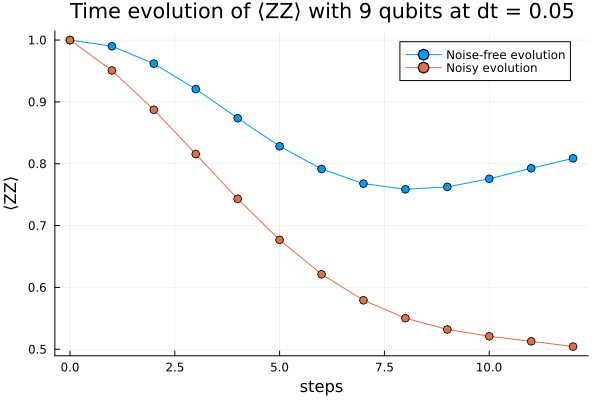

In [6]:
plot(0:steps, exact_expval_target, xlabel="steps", label="Noise-free evolution", marker=:o)
plot!(0:steps, noisy_expval_target, label="Noisy evolution", marker=:o)

if observable == obs_interaction(nq, topology)
    plot!(ylabel="⟨ZZ⟩", title ="Time evolution of ⟨ZZ⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
elseif observable == obs_magnetization(nq, topology)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
end

## ZNE

In [7]:
noise_levels = [1.0,1.3,1.5,1.8,2.0,2.2]
noisy_expval_target_levels = zne_time_evolution(nq, steps, topology, layer, J, h, dt; observable=observable, noise_levels=noise_levels, noise_kind="depolarizing");

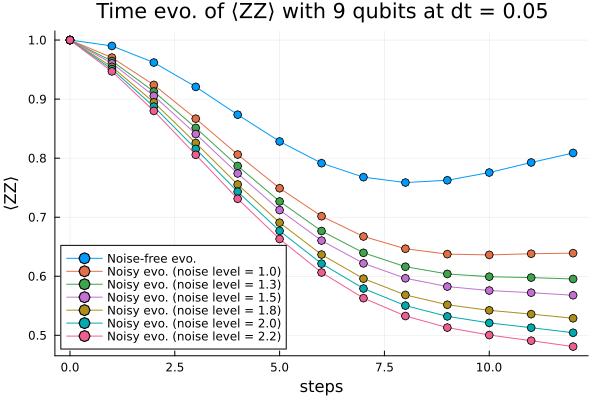

In [8]:
plot(0:steps, exact_expval_target, xlabel="steps", label="Noise-free evo.", marker=:o, legend=(0.1,0.3))
for i in 1:length(noise_levels)
    plot!(0:steps, noisy_expval_target_levels[i,:], label="Noisy evo. (noise level = $(noise_levels[i]))", marker=:o)
end

if observable == obs_interaction(nq, topology)
    plot!(ylabel="⟨ZZ⟩", title ="Time evo. of ⟨ZZ⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
elseif observable == obs_magnetization(nq, topology)
    plot!(ylabel="⟨Z⟩",title = "Time evo. of ⟨Z⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
end

In [9]:
noisy_exp_last = noisy_expval_target_levels[:,end];

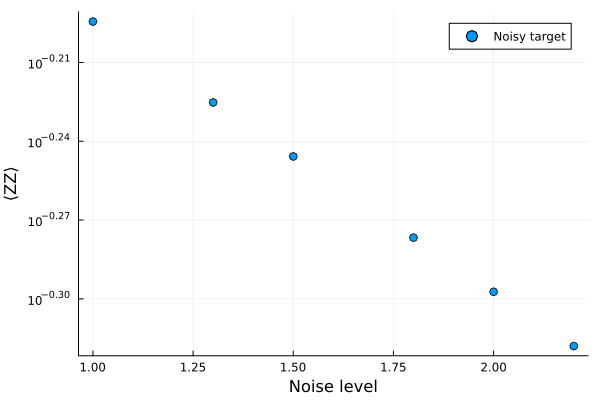

In [10]:
scatter(noise_levels, noisy_exp_last,
     xlabel="Noise level",
     ylabel="⟨ZZ⟩",
     label="Noisy target",
     marker=:o,
     legend=:topright, yaxis=:log)

In [11]:
corr_zne = zne(noisy_exp_last; exact_target_exp_value=exact_expval_target[end],noise_levels =noise_levels,fit_type="exponential", use_target=true)
println("Noisy value: ", round(noisy_exp_last[1], digits = 2))
println("Corrected value: ", round(corr_zne[1], digits = 2))
println("Absolute error before correction:", round(corr_zne[3], digits = 2))
println("Absolute error after correction:" ,round(corr_zne[2], digits = 5))

Noisy value: 0.64
Corrected value: 0.81
Absolute error before correction:0.17
Absolute error after correction:0.00015


In [12]:
corr_zne_lin, abs_after_zne_lin, abs_before_zne_lin = zne(noisy_expval_target_levels; exact_target_exp_value=exact_expval_target,noise_levels = noise_levels,fit_type="linear", use_target=true);

In [13]:
corr_zne_exp, abs_after_zne_exp, abs_before_zne_exp = zne(noisy_expval_target_levels; exact_target_exp_value=exact_expval_target,noise_levels = noise_levels,fit_type="exponential", use_target=true);

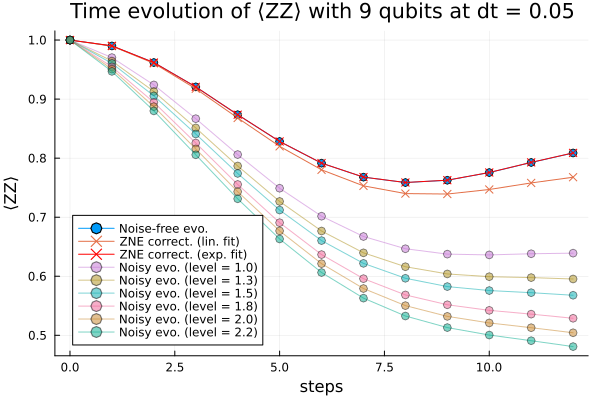

In [14]:
plot(0:steps, exact_expval_target, xlabel="steps", label="Noise-free evo.", marker=:o, legend=:bottomleft)

plot!(0:steps, corr_zne_lin, label="ZNE correct. (lin. fit)", marker=:x)
plot!(0:steps, corr_zne_exp, label="ZNE correct. (exp. fit)", marker=:x, color ="red")

for i in 1:length(noise_levels)
    plot!(0:steps, noisy_expval_target_levels[i,:], label="Noisy evo. (level = $(noise_levels[i]))", marker=:o, alpha = 0.5)
end
if observable == obs_interaction(nq, topology)
    plot!(ylabel="⟨ZZ⟩", title ="Time evolution of ⟨ZZ⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
elseif observable == obs_magnetization(nq, topology)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
end

## CDR

In [15]:
angle_definition = pi/20
list_training_thetas = training_circuit_generation_loose_perturbation(layer, J, h, dt, angle_definition; sample_function="small", num_samples=7);

In [16]:
exact_expvals_training = training_trotter_time_evolution(nq, steps, topology, layer, list_training_thetas; observable=observable, noise_kind="none");

In [17]:
noisy_expvals_training = training_trotter_time_evolution(nq, steps, topology, layer, list_training_thetas; observable=observable, noise_kind="depolarizing", depol_strength=0.02);

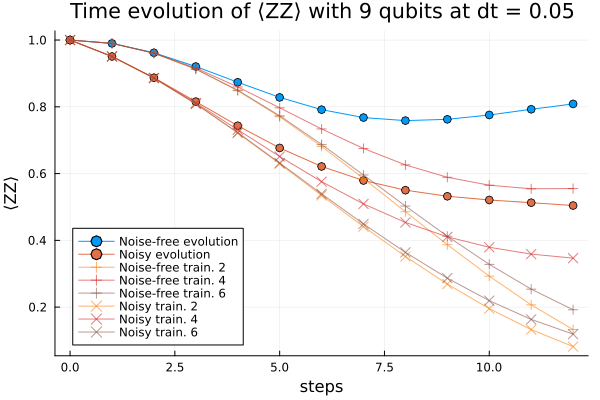

In [18]:
colors = palette(:tab10)
plot(0:steps, exact_expval_target; xlabel="steps", label="Noise-free evolution", marker=:o, legend=:bottomleft)
plot!(0:steps, noisy_expval_target; label="Noisy evolution", marker=:o)

for i in 2:2:length(exact_expvals_training)
    exact = exact_expvals_training[i]
    plot!(0:steps, exact; label="Noise-free train. $i", c=colors[i], marker=:+, markersize = 5, alpha=0.6)
end

for i in 2:2:length(noisy_expvals_training)
    noisy = noisy_expvals_training[i]
    plot!(0:steps, noisy; label="Noisy train. $i", color=colors[i], marker=:x, markersize = 5, alpha=0.6)
end

if observable == obs_interaction(nq, topology)
    plot!(ylabel="⟨ZZ⟩", title ="Time evolution of ⟨ZZ⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
elseif observable == obs_magnetization(nq, topology)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
end

In [19]:
noisy_expvals_training_last = [row[end] for row in noisy_expvals_training]
exact_expvals_training_last = [row[end] for row in exact_expvals_training]
noisy_expval_target_last = noisy_expval_target[end]
exact_expval_target_last = exact_expval_target[end]
corr_last, abs_error_after_cdr_last, abs_error_before_cdr_last = cdr(
    noisy_expvals_training_last,
    exact_expvals_training_last,
    noisy_expval_target_last;
    exact_target_exp_value=exact_expval_target_last,
    use_target=true
)
println("Noisy value at the last timestep: ", round(noisy_expval_target_last, digits = 2))
println("Corrected value at the last timestep: ", round(corr_last, digits = 2))
println("Absolute error before correction: ", round(abs_error_before_cdr_last,digits =2))
println("Absolute error after correction: ", round(abs_error_after_cdr_last, digits = 4))

Noisy value at the last timestep: 0.5
Corrected value at the last timestep: 0.81
Absolute error before correction: 0.3
Absolute error after correction: 0.0023


In [20]:
corr_cdr, abs_after_cdr, abs_before_cdr = cdr(
    noisy_expvals_training,
    exact_expvals_training,
    noisy_expval_target; exact_target_exp_value=exact_expval_target, use_target=true
);

In [21]:
#CDR with decaying weights
decay_weights_partial_mem = [
    [τ == t ? 1.0 : (τ == t-1 ? 0.5 : 0.0) for τ in 1:t]
    for t in 1:length(noisy_expvals_training[1])
]
corr_weight_partial_mem, abs_after_weight_partial_mem, abs_before_weight_partial_mem= cdr(
    noisy_expvals_training,
    exact_expvals_training,
    noisy_expval_target, decay_weights_partial_mem; exact_target_exp_value=exact_expval_target, use_target=true
);

decay_weights_linear = [[τ / t for τ in 1:t] for t in 1:length(noisy_expvals_training[1])]
corr_weight_lin, abs_after_weight_lin, abs_before_weight_lin = cdr(
    noisy_expvals_training,
    exact_expvals_training,
    noisy_expval_target, decay_weights_linear; exact_target_exp_value=exact_expval_target, use_target=true
);

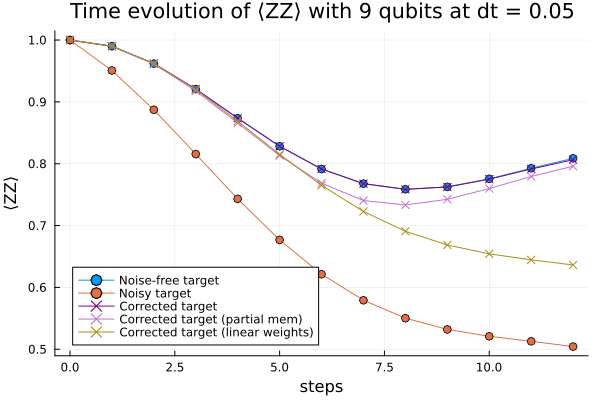

In [22]:
#plot time evolution
plot(0:steps, exact_expval_target; xlabel="steps", label="Noise-free target", marker=:o, legend=:bottomleft)
plot!(0:steps, noisy_expval_target; label="Noisy target", marker=:o)
plot!(0:steps, corr_cdr; label="Corrected target", marker=:x, color = "purple")
plot!(0:steps, corr_weight_partial_mem; label="Corrected target (partial mem)", marker=:x)
plot!(0:steps, corr_weight_lin; label="Corrected target (linear weights)", marker=:x)


if observable == obs_interaction(nq, topology)
    plot!(ylabel="⟨ZZ⟩", title ="Time evolution of ⟨ZZ⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
elseif observable == obs_magnetization(nq)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
end

## vnCDR

In [23]:
exact_expvals_training_levels = training_trotter_time_evolution(
    nq, steps, topology, layer,
    list_training_thetas;
    observable = observable,
    noise_kind = "none"
);

In [ ]:
noisy_expvals_training_levels = vnCDR_training_trotter_time_evolution(nq, steps, topology, layer, list_training_thetas; observable = observable, noise_kind="depolarizing",noise_levels = noise_levels);

6×7×13 Array{Float64, 3}:
[:, :, 1] =
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0

[:, :, 2] =
 0.970332  0.970332  0.970332  0.970332  0.970332  0.970332  0.970332
 0.96446   0.96446   0.96446   0.96446   0.96446   0.96446   0.96446
 0.960555  0.960555  0.960555  0.960555  0.960555  0.960555  0.960555
 0.954713  0.954713  0.954713  0.954713  0.954713  0.954713  0.954713
 0.950828  0.950828  0.950828  0.950828  0.950828  0.950828  0.950828
 0.946951  0.946951  0.946951  0.946951  0.946951  0.946951  0.946951

[:, :, 3] =
 0.922682  0.922683  0.922682  0.923269  0.923257  0.922746  0.923311
 0.911549  0.91155   0.911549  0.912128  0.912116  0.911612  0.91217
 0.904183  0.904184  0.904183  0.904757  0.904746  0.904246  0.904799
 0.893217  0.893219  0.893218  0.893785  0.893774  0.89328   0.893826
 0.885963  0.885964  0.88596

In [25]:
noisy_expvals_training_levels_end = noisy_expvals_training_levels[:,:,end];

In [26]:
exact_expvals_training_end = [row[end] for row in exact_expvals_training];

In [27]:
# "exponential" fit in the noise levels (fit_type="exponential")
pred_exp, abs_after_exp, abs_before_exp = vnCDR(
    noisy_expvals_training_levels_end,
    exact_expvals_training_end,
    noisy_exp_last;
    exact_target_exp_value=exact_expval_target[end],
    use_target=true, fit_type="exponential", fit_intercept=false
)

println("Noisy value at the last timestep: ", round(noisy_expval_target_last, digits = 2))
println("Corrected value at the last timestep: ", round(pred_exp[1], digits = 2))
println("Absolute error before correction: ", round(abs_before_exp[1], digits = 2))
println("Absolute error after correction: ", round(abs_after_exp[1], digits = 8))

┌ Info: Training machine(LinearRegressor(fit_intercept = false, …), …).
└ @ MLJBase /home/julia/.julia/packages/MLJBase/F1Eh6/src/machines.jl:499
┌ Info: Solver: Analytical
│   iterative: Bool false
│   max_inner: Int64 200
└ @ MLJLinearModels /home/julia/.julia/packages/MLJLinearModels/yYgtO/src/mlj/interface.jl:27
┌ LogLevel(100): params , (coefs = [:x1 => 41.8824206981465, :x2 => -132.87939354640838, :x3 => 91.23758489054168, :x4 => 74.02752791227374, :x5 => -109.72385373631592, :x6 => 36.45571374455315], intercept = nothing)
└ @ Main /home/julia/files/EPFLph/MA4/QIC_project/pp-em/cdr/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:828
┌ LogLevel(100): coefs , [41.8824206981465, -132.87939354640838, 91.23758489054168, 74.02752791227374, -109.72385373631592, 36.45571374455315]
└ @ Main /home/julia/files/EPFLph/MA4/QIC_project/pp-em/cdr/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:832


Noisy value at the last timestep: 0.5
Corrected value at the last timestep: 0.81
Absolute error before correction: 0.33
Absolute error after correction: 0.0


┌ LogLevel(100): noisy_target_exp_value , [-0.4476637560240896, -0.518584534473335, -0.5659406390248478, -0.6370887174914697, -0.6845970331420472, -0.7321666109610854]
└ @ Main /home/julia/files/EPFLph/MA4/QIC_project/pp-em/cdr/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:833
┌ LogLevel(100): pred , 0.80877471008584
└ @ Main /home/julia/files/EPFLph/MA4/QIC_project/pp-em/cdr/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:844


In [28]:
#fitting to a hyperplane (fit_type="linear" by default)
pred, abs_after, abs_before = vnCDR(
    noisy_expvals_training_levels_end,
    exact_expvals_training_end,
    noisy_exp_last; exact_target_exp_value = exact_expval_target[end], use_target=true, lambda = 0.0
)
println("Noisy value at the last timestep: ", round(noisy_expval_target_last, digits = 3))
println("Corrected value at the last timestep: ", round(pred[1], digits = 3))
println("Absolute error before correction: ", round(abs_before[1], digits = 3))
println("Absolute error after correction: ", round(abs_after[1], digits = 12))

┌ Info: Training machine(LinearRegressor(fit_intercept = false, …), …).
└ @ MLJBase /home/julia/.julia/packages/MLJBase/F1Eh6/src/machines.jl:499
┌ Info: Solver: Analytical
│   iterative: Bool false
│   max_inner: Int64 200
└ @ MLJLinearModels /home/julia/.julia/packages/MLJLinearModels/yYgtO/src/mlj/interface.jl:27


Noisy value at the last timestep: 0.504
Corrected value at the last timestep: 0.809
Absolute error before correction: 0.328
Absolute error after correction: 4.73e-10


┌ LogLevel(100): params , (coefs = [:x1 => 19.837037998231764, :x2 => -26.66479580478481, :x3 => -12.258043339935554, :x4 => 18.487176473874875, :x5 => 17.993609603806302, :x6 => -16.396323729343422], intercept = nothing)
└ @ Main /home/julia/files/EPFLph/MA4/QIC_project/pp-em/cdr/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:828
┌ LogLevel(100): coefs , [19.837037998231764, -26.66479580478481, -12.258043339935554, 18.487176473874875, 17.993609603806302, -16.396323729343422]
└ @ Main /home/julia/files/EPFLph/MA4/QIC_project/pp-em/cdr/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:832
┌ LogLevel(100): noisy_target_exp_value , [0.6391195480044367, 0.5953626671654835, 0.567825776387545, 0.528829757974924, 0.5042934021639226, 0.48086601106292]
└ @ Main /home/julia/files/EPFLph/MA4/QIC_project/pp-em/cdr/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:833
┌ LogLevel(100): pred , 0.8087747097321634
└ @ Main /home/julia/files/EPFLph/MA4/

In [29]:
corr_vnCDR_lin, abs_after_vnCDR_lin, abs_before_vnCDR_lin = vnCDR(
    noisy_expvals_training_levels,
    exact_expvals_training,
    noisy_expval_target_levels; exact_target_exp_value=exact_expval_target, use_target=true
);

┌ Info: Training machine(LinearRegressor(fit_intercept = false, …), …).
└ @ MLJBase /home/julia/.julia/packages/MLJBase/F1Eh6/src/machines.jl:499
┌ Info: Solver: Analytical
│   iterative: Bool false
│   max_inner: Int64 200
└ @ MLJLinearModels /home/julia/.julia/packages/MLJLinearModels/yYgtO/src/mlj/interface.jl:27
┌ LogLevel(100): params , (coefs = [:x1 => 0.16666666666666657, :x2 => 0.16666666666666663, :x3 => 0.16666666666666663, :x4 => 0.16666666666666663, :x5 => 0.16666666666666663, :x6 => 0.16666666666666663], intercept = nothing)
└ @ Main /home/julia/files/EPFLph/MA4/QIC_project/pp-em/cdr/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:828
┌ LogLevel(100): coefs , [0.16666666666666657, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663]
└ @ Main /home/julia/files/EPFLph/MA4/QIC_project/pp-em/cdr/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:832
┌ LogLevel(100): noisy_target_exp_value , [1

In [30]:
corr_vnCDR_exp, abs_after_vnCDR_exp, abs_before_vnCDR_exp = vnCDR(
    noisy_expvals_training_levels,
    exact_expvals_training,
    noisy_expval_target_levels; exact_target_exp_value=exact_expval_target, use_target=true, fit_type="exponential"  
);

┌ Info: Training machine(LinearRegressor(fit_intercept = false, …), …).
└ @ MLJBase /home/julia/.julia/packages/MLJBase/F1Eh6/src/machines.jl:499
┌ Info: Solver: Analytical
│   iterative: Bool false
│   max_inner: Int64 200
└ @ MLJLinearModels /home/julia/.julia/packages/MLJLinearModels/yYgtO/src/mlj/interface.jl:27
┌ LogLevel(100): params , (coefs = [:x1 => 0.0, :x2 => 0.0, :x3 => 0.0, :x4 => 0.0, :x5 => 0.0, :x6 => 0.0], intercept = nothing)
└ @ Main /home/julia/files/EPFLph/MA4/QIC_project/pp-em/cdr/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:828
┌ LogLevel(100): coefs , [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
└ @ Main /home/julia/files/EPFLph/MA4/QIC_project/pp-em/cdr/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:832
┌ LogLevel(100): noisy_target_exp_value , [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
└ @ Main /home/julia/files/EPFLph/MA4/QIC_project/pp-em/cdr/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:833
┌ LogLevel(100): pred , 1.0
└ @ M

## Final comparison

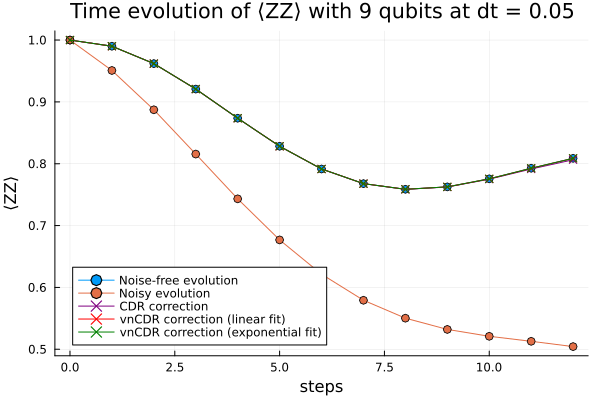

In [ ]:
plot(0:steps, exact_expval_target; xlabel="steps", label="Noise-free evolution", marker=:o, legend=:bottomleft)
plot!(0:steps, noisy_expval_target; label="Noisy evolution", marker=:o)
plot!(0:steps, corr_cdr; label="CDR correction", marker=:x, color = "purple")
plot!(0:steps, corr_vnCDR_lin; label="vnCDR correction (linear fit)", marker=:x, color = "red")
plot!(0:steps, corr_vnCDR_exp; label="vnCDR correction (exponential fit)", marker=:x, color = "green")

if observable == obs_interaction(nq, topology)
    plot!(ylabel="⟨ZZ⟩", title ="Time evolution of ⟨ZZ⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
elseif observable == obs_magnetization(nq)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
end

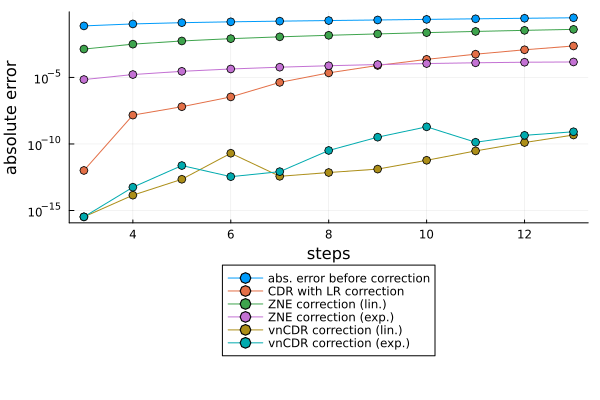

In [32]:
start = 3

plot(start:steps+1, abs_before_cdr[start:end], xlabel="steps", ylabel = "absolute error", label="abs. error before correction", marker=:o, legend=:outerbottom, yscale=:log10)


# plain CDR and weighted CDR
plot!(start:steps+1, abs_after_cdr[start:end], label="CDR with LR correction", marker=:o)

# plain ZNE
plot!(start:steps+1, abs_after_zne_lin[start:end], label="ZNE correction (lin.)", marker=:o)
plot!(start:steps+1, abs_after_zne_exp[start:end], label="ZNE correction (exp.)", marker=:o)

# vnCDR
plot!(start:steps+1, abs_after_vnCDR_lin[start:end], label="vnCDR correction (lin.)", marker=:o, yscale=:log10)
plot!(start:steps+1, abs_after_vnCDR_exp[start:end], label="vnCDR correction (exp.)", marker=:o, yscale=:log10)